In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

from skimage.io import imread
from scipy.signal import convolve2d

from scipy.stats import cauchy, norm #chi2, erlang, expon, genexpon, ncx2, poisson, powerlaw, rayleigh

In [10]:
# image_list = glob('/home/pvt/Workspace/multibeam-classification/dataset-1/*raw.png') # window set to 2.25m to 11.25m
image_list = glob('/home/pvt/Workspace/multibeam/data/DIDSON/2016-07-19.11/*raw.png') # window set to 2.25m to 11.25m
print len(image_list)

import cv2
from multibeam import Sonar
from didson import Didson

didson = Didson();
didson.loadConfig('data/DIDSON/didson.json')

41487
Resolution
Desired: 0.02 , x: 0.0199847165996 , y: 0.0200030206842
Resolution
Desired: 0.02 , x: 0.019980559264 , y: 0.0200144258506


image: 36944
0.0 0.494117647059
(512, 96)


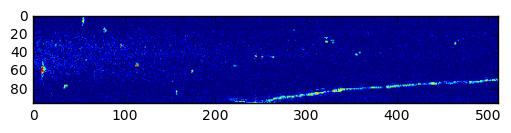

In [78]:
idx = np.random.randint(0,len(image_list))
# idx=30950
# idx=36944 - sparse fish
# idx=40891 - reverb

print 'image:',idx
# img = imread(image_list[idx], as_grey=True)
ping = cv2.imread(image_list[idx],cv2.CV_LOAD_IMAGE_GRAYSCALE)
img = didson.deconvolve(ping)
# img = ping
img = img.astype(np.float64)/255.0
print np.amin(img), np.amax(img)
print img.shape
plt.imshow(img.transpose())

ERROR:root:Line magic function `%print` not found.


u0: 0.0635573448985 - 2.94948096886
u1: -524.4125 - 4.0
s: 0.105
changes: 96
iterations: 1


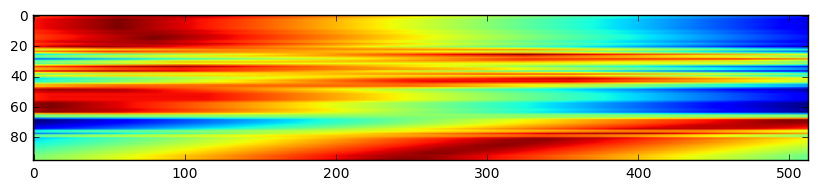

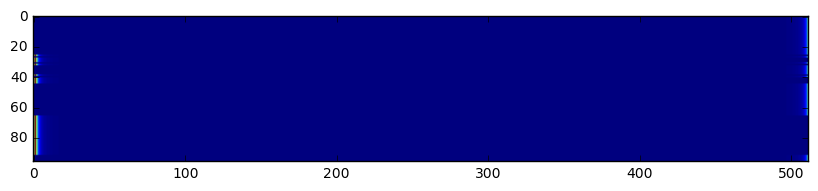

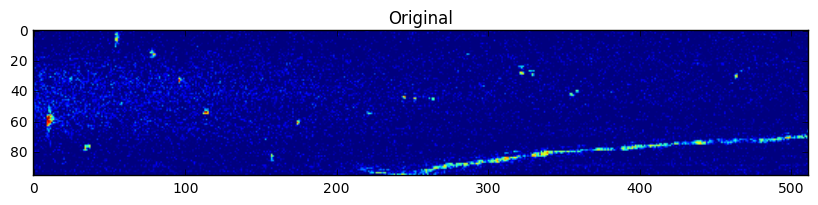

In [106]:
# %%timeit

"""
Tunable parameters:
- Cauchy scale
- Transition cost & cooling
- relative weight (u0/u1)
- 1st-order void-label cost

To Do:
- better edge handling on roll 
- handle "void" labels on transition cost (should get replaced by fixed cost!)
- try other transition weights (not just normal) - e.g. triangular, parabolic, square window
- speed up computation (need <0.1/loop)
"""


# c_scale = 0.33
c_scale = 1
void_cost = .50
w1 = 0.5

#get a prior on the labels
midx = np.argmax(img, axis=0) # return max location per row
midx.shape = (1,96)

# pre-allocate vector used to evaluate Cauchy functions
x = np.arange(0.0,512.0, 1.0)
x.shape = (512,1)
x = np.tile(x,(1,96))
    
# c = cauchy.pdf(x, loc = midx, scale=0.33)    
# u0 = np.sum(np.square)
# u0void = np.square

# compute 0-order label cost map 
u0 = np.zeros_like(x)
    
# one for each range assignment
# this is taking most of the time (>2s)
for i in range(0,512):
    u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)
    
# 'void' label
u0v = 2*np.sum(np.square(img),axis=0) 
u0 = np.vstack((u0v,u0))

s = 0.1
# now, iterate so as to get 
# for i in range(0,10):
i = 0
while True:
    i = i+1
    
    a = np.tile(midx,(512,1))
    l = np.roll(a,1,axis=1)
    l[:,0]=l[:,1]
    ll = np.roll(l,1, axis=1)
    ll[:,0]=ll[:,1]
    r = np.roll(a,-1,axis=1)
    r[:,-1] = r[:,-2]
    rr = np.roll(r,-1, axis=1)
    rr[:,-1] = rr[:,-2]  

    # "cooling" schedule
#     s = 0.95*s;
    s = 1.05*s
#     u1 = 2 - 2.5*s*norm.pdf((l-x),loc=0, scale=s ) - 2.5*s*norm.pdf((r-x),loc=0, scale=s )
#     u1 = 4 - 2.5*s*norm.pdf((l-x),loc=0, scale=s ) - 2.5*s*norm.pdf((r-x),loc=0, scale=s ) - 2.5*s*norm.pdf((ll-x),loc=0, scale=s ) - 2.5*s*norm.pdf((rr-x),loc=0, scale=s )
    u1 = 4 - 2.5*s*np.absolute(l-x) - 2.5*s*np.absolute(r-x) - 2.5*s*np.absolute(ll-x) - 2.5*s*np.absolute(rr-x)
    u1 = np.vstack((void_cost*np.ones_like(u0v),u1))

    print 'u0:',np.amin(u0),'-',np.amax(u0)
    print 'u1:',np.amin(u1),'-',np.amax(u1)
    print 's:',s
    cost = u0/np.amax(u0) + u1/np.amax(u1)
    
    midx_new = np.argmin(cost, axis=0)

#     print np.amin(cost),np.amax(cost)
#     print u0.shapes
#     midx_new = np.argmin(u0, axis=0)

    changes = np.sum((midx-midx_new)!=0)
#     print 'changes:',changes
    midx = midx_new
    
#     plt.figure(figsize=(10,4))
#     plt.imshow((cost).transpose())
    
    if s<5:
        break
    
    if changes<=0:
        break
        
    if i>100:
        break

print 'changes:', changes
        
print 'iterations:',i
plt.figure(figsize=(10,4))
plt.imshow(cost.transpose())
        
simg = cauchy.pdf(x,loc=midx, scale=c_scale)
plt.figure(figsize=(10,4))
plt.imshow(simg.transpose())

plt.figure(figsize=(10,4))
plt.imshow(img.transpose())
plt.title('Original') 

%print midx

In [98]:
# %%timeit

c_scale = 2.0

# empty beams will square-integrate to < 0.1
# beams with returns will integrate to > 0.2
# plt.plot(np.sum(np.square(img),axis=0))

# for i in range(0, 512):
#     u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)

i=range(0,512)
u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)

    
a = cauchy.pdf(x, loc = x, scale =c_scale)
# print a.shape

plt.figure()
plt.imshow(u0.transpose())
plt.figure()
plt.imshow(a.transpose())

TypeError: can only concatenate list (not "float") to list

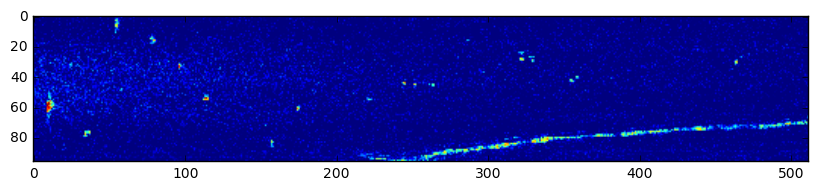

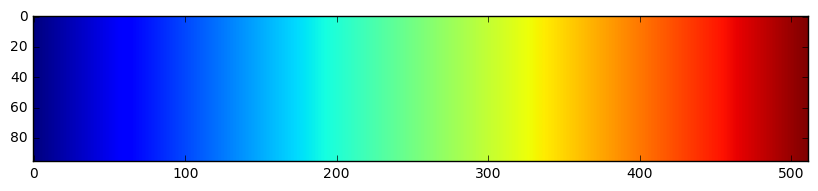

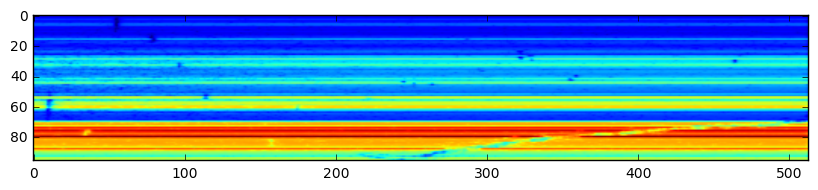

In [126]:
plt.figure(figsize=(10,10))
plt.imshow(img.transpose())

x = np.arange(0.0,512.0, 1.0)
x.shape = (512,1)
x = np.tile(x,(1,96))
plt.figure(figsize=(10,10))
plt.imshow(x.transpose())

for i in range(0, 512):
    u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)

plt.figure(figsize=(10,10))
plt.imshow(u0.transpose())
    
# midx = np.argmax(img, axis=0) # return max location per row
# midx.shape = (1,96)
# print x.shape
# xv = x
# xv.shape =(512,96,1)
# xv = np.tile(x,(1,1,512))
# print xv.shape
# a = cauchy.pdf(xv, loc=x, scale = c_scale)
    u0[i,:] = np.sum(np.square(img - cauchy.pdf(x, loc=i+0.0, scale = c_scale)),axis=0)
# print a.shape

In [143]:
x = np.arange(0.0,512.0, 1.0)
x.shape = (512,1)
x = np.tile(x,(1,96))
# xv = x
# xv.shape =(512,96,1)
# xv = np.tile(x,(1,1,512))
u0 = cauchy.pdf((x,x), loc=(midx, midx), scale = c_scale)
u0.shape
# u0 = np.sum(np.square(img - cauchy.pdf(xv, loc=x, scale = c_scale)),axis=0)
# print u0.shape
# plt.imshow(u0[:,:,100].transpose())

(2, 512, 96)